In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import trange
import pickle

from celluloid import Camera
from IPython import display
from IPython.core.display import HTML

In [2]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\ffmpeg\bin\ffmpeg.exe'

In [3]:
def spinson_independent_flip(opinions, spinson):
    opinions[spinson] = -1 if opinions[spinson] == 1 else 1
    
    return opinions

In [4]:
def spinson_conformity_flip(graphs, opinions, spinson, q):
    neighbours = []
    # I don't choose neighbours from social network graph
    # Choosing q neighbours from all considered graphs
    for graph in graphs[:-1]: 
        if len(list(graph.neighbors(spinson))) < q:
            neighbours.extend(list(graph.neighbors(spinson)))
        else:
            neighbours.extend(random.sample(list(graph.neighbors(spinson)), q))
    neighbours_opinions = [opinions[neighbour] for neighbour in neighbours]
    # in a set of neighbours opinions there is only one value
    # edge between social media node and spinson has the same value as other neighbours
    if len(set(neighbours_opinions)) == 1 and graphs[-1].edges[(66, spinson)]['media'][0] == neighbours_opinions[0]:
        opinions[spinson] = neighbours_opinions[0]

    return opinions

In [5]:
def q_voter_simulation(graphs, p, q, iterations):
    magnetization = [1]
        
    opinions = [1] * len(graphs[0].nodes())
    for i in range(iterations):
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly? 
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip(graphs, opinions, spinson, q)

        magnetization.append(sum(opinions)/len(graphs[0]))
        
    return magnetization

In [6]:
def calculate_average_magnetization_final(graphs, ps, q, mc):
    magnetizations = []
    for j in trange(len(ps)):  
        magnetization = np.zeros(mc)
        for i in range(mc):    
            magnetization = magnetization + q_voter_simulation(graphs, ps[j], q, mc)
        magnetizations.append(magnetization[-1]/mc)
        
    return magnetizations

## Loading created networks

In [7]:
G = nx.read_gpickle('network_neighbourhood.pickle')
K = nx.read_gpickle('social_neighbourhood.pickle')
L = nx.read_gpickle('social_media.pickle')

#### Position of nodes

In [8]:
with open('neighbourhood_position.pickle', 'rb') as handle:
    pos = pickle.load(handle)

#### Size of nodes

In [9]:
node_sizes = [y*200 for x, y in sorted(K.degree)]

## Visualisation of networks

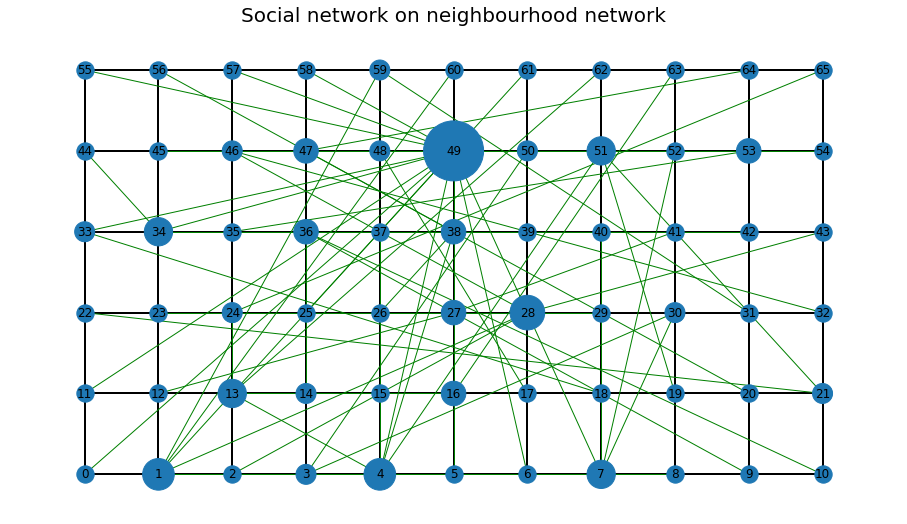

In [10]:
plt.figure(figsize=(16, 9))
plt.title('Social network on neighbourhood network', fontsize=20)
nx.draw(G, edge_color=['black']*len(G), pos=pos, width=2, node_size=node_sizes)
nx.draw(K, edge_color=['green']*len(G), pos=pos, with_labels=True)

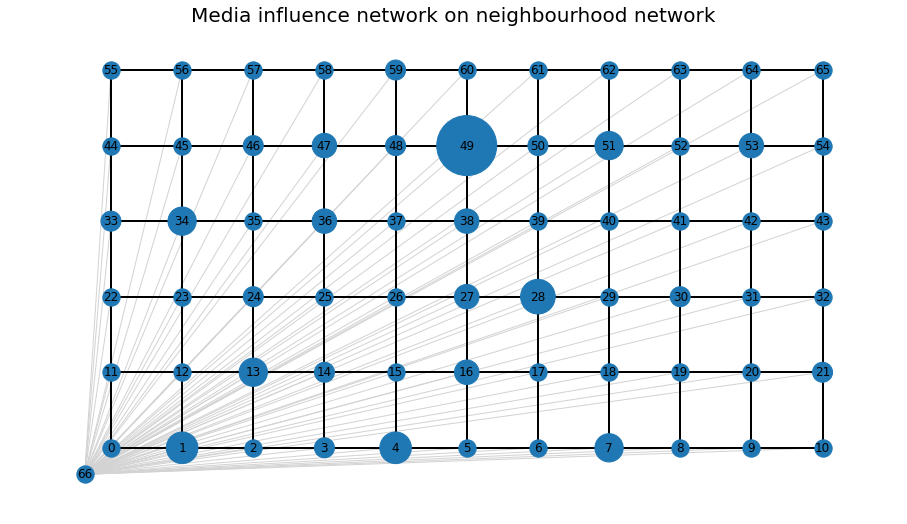

In [11]:
plt.figure(figsize=(16, 9))
plt.title('Media influence network on neighbourhood network', fontsize=20)
nx.draw(L, edge_color=['lightgray']*len(G), pos=pos, with_labels=True)
nx.draw(G, edge_color=['black']*len(G), pos=pos, width=2, node_size=node_sizes)

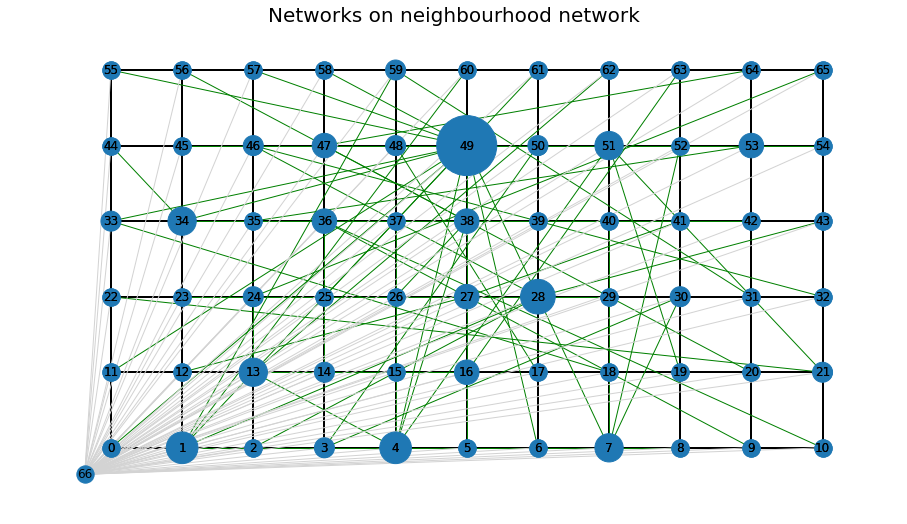

In [12]:
plt.figure(figsize=(16, 9))
plt.title('Networks on neighbourhood network', fontsize=20)
nx.draw(G, edge_color=['black']*len(G), pos=pos, width=2, node_size=node_sizes)
nx.draw(K, edge_color=['green']*len(G), pos=pos, with_labels=True)
nx.draw(L, edge_color=['lightgray']*len(G), pos=pos, with_labels=True)

In [13]:
K_temp = nx.fast_gnp_random_graph(len(G.nodes()), 0.07)

In [14]:
graphs = [G, K, K_temp, L]

#### Graphs - list od creates graphs in a specific order:

- graphs[0] - G - rectangular neighbourhood network
- graphs[1] - K - social interactions network
- graphs[2] - K_temp - temporary social interactions network
- graphs[-1] - L -social media network

In [26]:
def q_voter_simulation_v2(graphs, p, q, iterations):
    magnetization = []

    opinions = [1]*len(G)
    while opinions.count(-1) < 2:
        opinions[random.randint(0, len(G)-1)] = -1
    
    social_media_opinion = [1] 
    opinions = opinions + social_media_opinion
    
    magnetization.append(sum(opinions[:-1])/len(graphs[0]))
    
    for i in range(iterations):
        # in every iteration graph of temporary interactions and opinion of social media is changing
        graphs[2] = nx.fast_gnp_random_graph(len(graphs[0].nodes()), 0.07)
        opinions[-1] = random.choice([-1, 1]) # social media influence change opinion
        # choosing neighbours
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly?
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip_v2(graphs, opinions, spinson, q)

        magnetization.append(sum(opinions[:-1])/len(graphs[0]))
        
    return magnetization

In [27]:
def spinson_conformity_flip_v2(graphs, opinions, spinson, q):
    neighbours = []
    # I don't choose neighbours from social network graph
    # Choosing q neighbours from all considered graphs
    for graph in graphs: 
        if len(list(graph.neighbors(spinson))) < q:
            neighbours.extend(list(graph.neighbors(spinson)))
        else:
            neighbours.extend(random.sample(list(graph.neighbors(spinson)), q))
    neighbours_opinions = [opinions[neighbour] for neighbour in neighbours]
    # in a set of neighbours opinions there is only one value
    # edge between social media node and spinson has the same value as other neighbours
    if len(set(neighbours_opinions)) == 1 and graphs[-1].edges[(66, spinson)]['media'][0] == neighbours_opinions[0]:
        opinions[spinson] = neighbours_opinions[0]

    return opinions

In [28]:
number_of_edges = [len(graph.edges()) for graph in graphs]

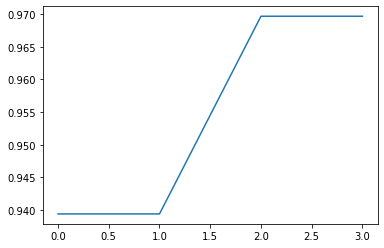

In [29]:
x = q_voter_simulation_v2(graphs, 1/1000, 10, 3)
plt.plot(x)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.82s/it]


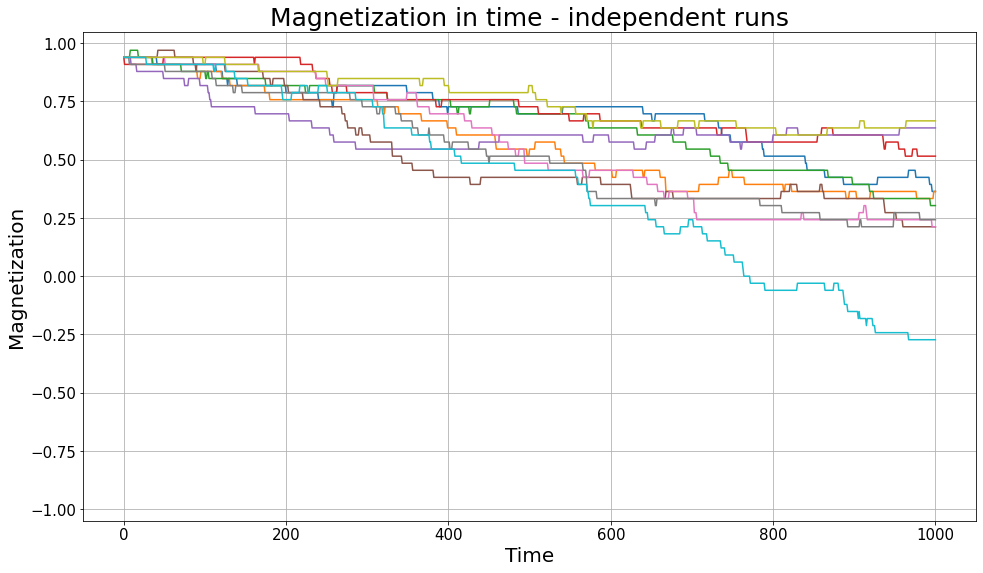

In [30]:
plt.figure(figsize=(16, 9))
for _ in trange(10):
    x = q_voter_simulation_v2(graphs, 1/1000, 2, 1000)
    plt.plot(x)
plt.ylim(-1.05, 1.05)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Magnetization', fontsize=20)
plt.title('Magnetization in time - independent runs', fontsize=25)
plt.grid()

## Simulation

Layer of neighbourhood - rectangular (2d grid layout) network, which represents a node and their neighbours. <font color='green' size="2"><b> Done </b></font>

In [20]:
def q_voter_simulation_visualization(graphs, p, q, iterations):
    fig = plt.figure(figsize=(12, 8))
    camera = Camera(fig)
    
    opinions = [1] * len(graphs[0].nodes())
    for i in range(iterations):
        for i in range(len(graphs[0])):
            spinson = random.choice(list(graphs[0].nodes()))  #  chooses one random node
            if random.random() < p:  #  does it act independtly? 
                if random.random() < 0.5:  # the same probability to change opinion
                    opinions = spinson_independent_flip(opinions, spinson)
            else:
                opinions = spinson_conformity_flip(graphs, opinions, spinson, q)
        
        colors = ['#808080' if opinion == 1 else '#f6f7be' for opinion in opinions]      
        nx.draw(G, edge_color=['black']*len(G), node_color=colors, pos=pos, width=2, node_size=node_sizes, with_labels=True)
        camera.snap()
    
    animation = camera.animate()
    plt.close()
    
    return animation 

Layer of social interaction - Barabasi Albert Graph with different number of newly connected nodes (confirmed) <font color='green' size="2"><b> Done </b></font>

Layer of social media - how it can affect other nodes? Can the strength of such an influence be different in each step of iteration? <font color='green' size="2"><b> Done </b></font>

Layer of temporary connection - what about some different unusual meetings in the network? <font color='green' size="2"><b> Done </b></font>

Additional layer - vertical connection with the same index of a node, without horizontal connection. This graph could represent utility of each node. It means some nodes from the beginning wouldn't be able to change their opinion i.e. at the beginning of simulation their coefficient of e.g. attitude to environemntal issues or income are too small to change (buy) EV. Social network couldn't help in this situation. Neighbours can't affect for opinion of a node.

Weight of layer of temporary connection should be fewer than standard social interaction

social_media_opinion = [1] - for now it's constant, it can't be changes